# Hälsodataanalys

### Irene Grisenti - 28/11/2025

Detta projekt innehåller en analys av hälsodata med fokus på  [...].

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from src.analyzer import *
from src.stats_tests import *

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["figure.dpi"] = 120
np.set_printoptions(precision=3)
pd.set_option("display.precision", 3)
plt.style.use("ggplot")

## Förberedelser

I den första delen laddar jag in datasetet och genomför en initial utforskning.  
Målet är att förstå datastrukturen, kontrollera om det finns saknade värden eller dubbletter samt ta fram grundläggande beskrivande statistik.  
Denna förberedelse säkerställer att data är redo för vidare analys och visualiseringar.  

**Inledande observation**
- Datasetet innehåller 800 rader, 9 kolumner. Inga saknade värden eller dubbletter

- Datatyper: 
    - Numeriska kontinuerliga: height, weight, systolic_bp, cholesterol
    - Numeriska diskreta: id, age, disease
    - Kategoriska: sex, smoker

- Range och fördelning:
    - Ålder varierar mellan 18 och 90 år, med ett medelvärde på cirka 49 år
    - Längd och vikt ligger inom rimliga intervall för vuxna
    - Blodtryck och kolesterol har också sannolika värden

In [2]:
# Läsning av datasetet
df = pd.read_csv("data/health_study_dataset.csv")

# Skapa ett HealthAnalyzer-objekt
analyzer = HealthAnalyzer(df)

# Utforska datasetet
analyzer.explore()

# Städning
analyzer.cleaning()

Data sample:
      id  age sex  height  weight  systolic_bp  cholesterol smoker  disease
471  472   18   M   174.3    75.0        142.0         3.33     No        0
703  704   28   M   177.6    86.8        136.8         4.30     No        0
458  459   41   M   184.4    65.2        128.6         4.49     No        0
270  271   71   F   163.4    76.0        175.2         5.46     No        0
174  175   54   F   165.6    54.3        160.8         4.02    Yes        0

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           800 non-null    int64  
 1   age          800 non-null    int64  
 2   sex          800 non-null    object 
 3   height       800 non-null    float64
 4   weight       800 non-null    float64
 5   systolic_bp  800 non-null    float64
 6   cholesterol  800 non-null    float64
 7   smoker       800 non-null    object 


## Beskrivande analys

I detta steg utför jag en beskrivande analys av datasetet för att bättre förstå vår population och dess hälsomått.  
Jag tittar på centrala tendenser (medelvärde, median, min och max) och visualiserar olika aspekter av datan för att identifiera mönster och relationer mellan variabler.

- Beräkning av medelvärde, median, min och max för age, weight, height, systolic_bp och cholesterol.
- Visualizing:
    - Population overview: 
        - Age distribution by gender
        - Percentage of smokers vs non-smokers
    - Health metrics:
        - BMI distribution
        - Cholesterol levels by gender
    - Relationships:
        - Age vs Cholesterol
        - Systolic BP for people with/without disease

**Insikter**:
- Män och kvinnor är ganska jämnt representerade över åldersspektrumet och förekomsten av rökare är låg.
- Normal viktintervall med få extremvärden. Liknande kolesterolnivåer mellan kvinnor och män.
- Scatter-diagrammet visar att kolesterolnivån tenderar att öka med åldern. 
- Det systoliska blodtrycket är liknande mellan grupper med eller utan sjukdom, vilket tyder på att det systoliska blodtrycket ensam inte kan indikera en grupp med eller utan sjukdom.

In [3]:
specific_stats = analyzer.compute_stats(["age","weight","height"])
print(specific_stats)

           age   weight   height
mean    49.426   73.413  171.849
median  50.000   73.200  171.350
min     18.000   33.700  144.400
max     90.000  114.400  200.400


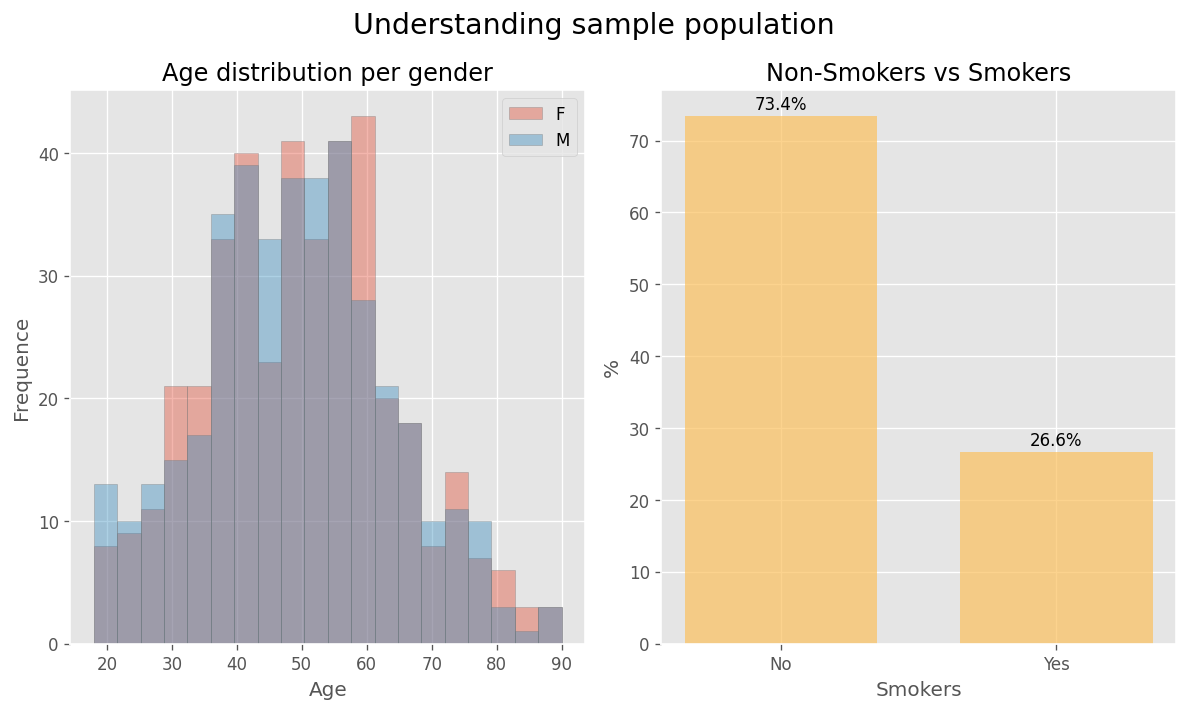

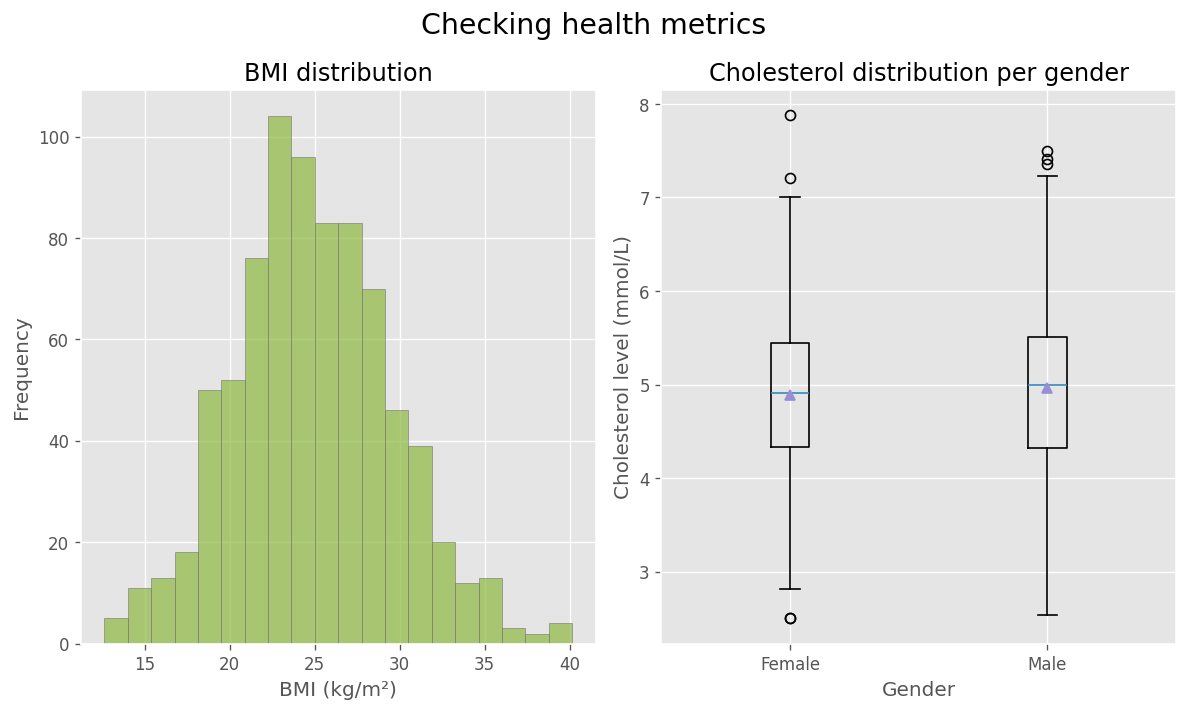

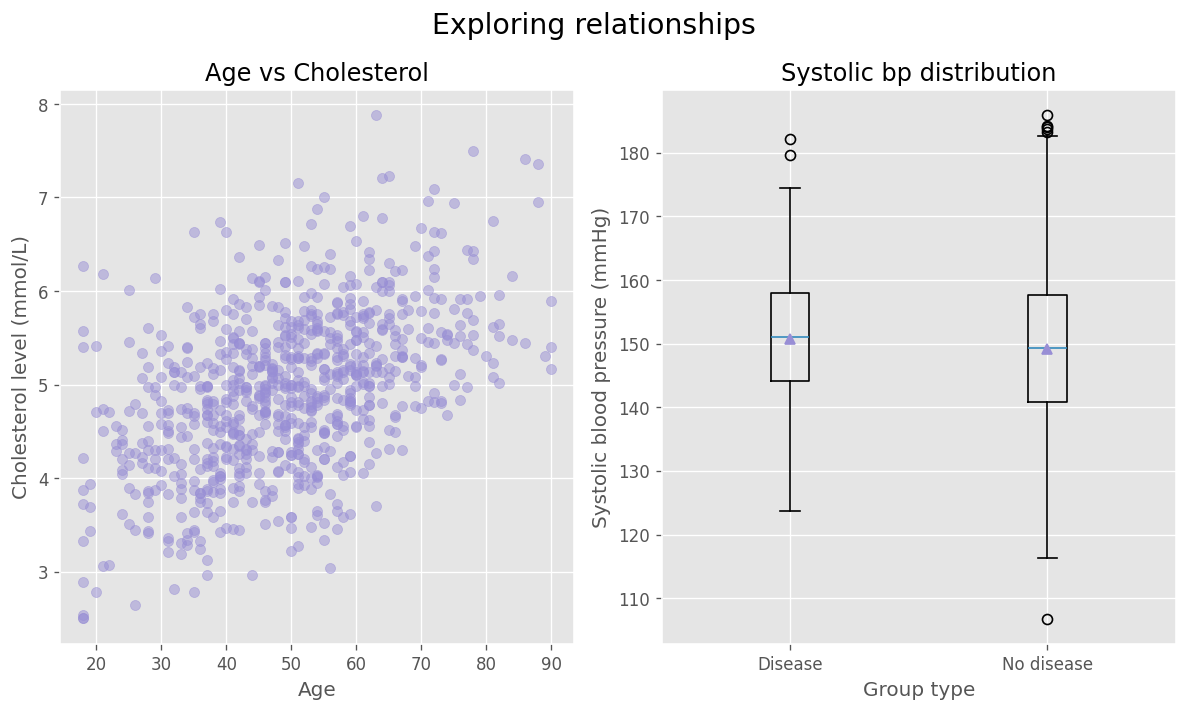

In [4]:
analyzer.plot_population_overview("img/fig1")
analyzer.plot_health_metrics("img/fig2")
analyzer.plot_relationships("img/fig3")

## Simulering av sjukdomsförekomst

I detta steg simulerar jag sjukdomsförekomst i en population med samma prevalens som i vårt dataset.  
Syftet är att jämföra den simulerade sjukdomsfrekvensen med den verkliga frekvensen i datan och se hur mycket slumpen kan påverka resultaten.  

Genom simuleringen kan vi:
- Förstå variationen i sjukdomsförekomst vid upprepade slumpmässiga urval.  
- Kontrollera om datasetets sjukdomsfrekvens ligger inom det förväntade intervallet.

**Resultat**:  
[...]

**Tolkning**:  
Skillnaden mellan den verkliga sjukdomsfrekvensen (5.87) och den simulerade sjukdomsfrekvensen (5.4) är liten och ligger inom den förväntade variationen.

In [5]:
analyzer.simulation_disease(n=1000, seed=42)

{'verklig förekomst': np.float64(5.875),
 'simulerad förekomst': np.float64(5.4),
 'skillnad': np.float64(-0.47)}

## Konfidensintervall för systoliskt blodtryck

I detta steg uppskattar vi 95% konfidensintervall för systoliskt blodtryck med två metoder:

1. **Normal Approximation** – antar att medelvärdet för urvalet är ungefär normalt fördelat.
2. **Bootstrap** – en resampling-metod som inte gör antaganden om fördelningen.

Syftet är att:
- Visa osäkerheten i vårt uppskattade medelvärde.  
- Jämföra resultaten från en analytisk metod (normalapproximation) med en mer flexibel, data-driven metod (bootstrap).  
- Bedöma om normalapproximationen är rimlig för detta dataset.

**Resultat:**  
[...]

**Tolkning**:  
Båda metoderna ger mycket liknande resultat, vilket tyder på att normalapproximationen är rimlig och att samplingfördelningen för medelvärdet är nära normal.

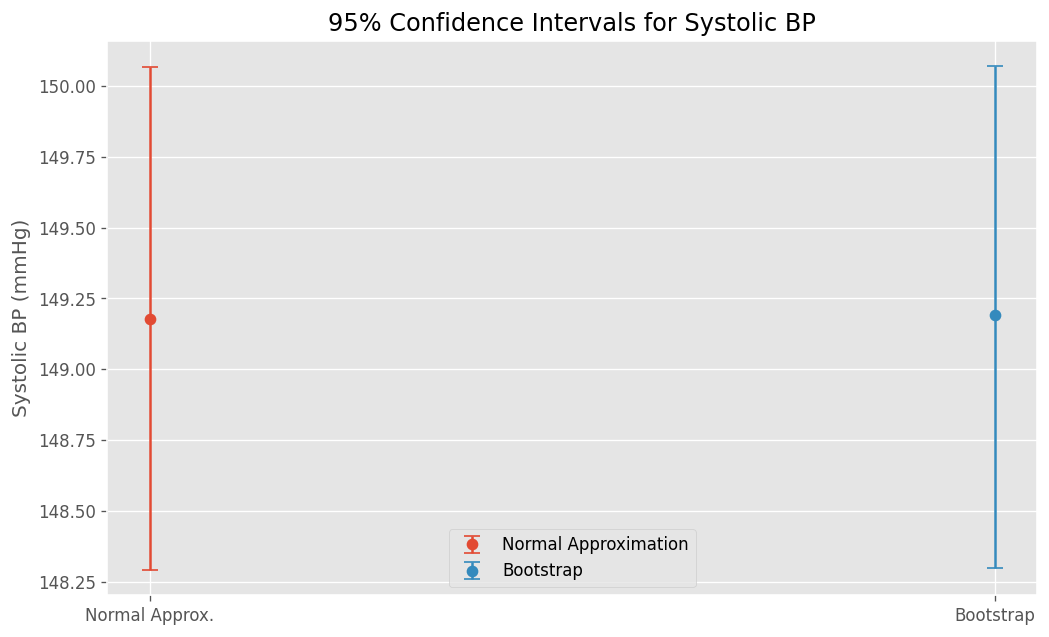

Punktuppskattning                     : 149.18
Standardavvikelse                     : 12.79

Resultatet av normalapproximationen är: 148.29 - 150.07

Resultatet från bootstrap är          : 148.30 - 150.07
Medelvärde för statistiken            : 149.19




{'Punktuppskattning': np.float64(149.178625),
 'Standardavvikelse': np.float64(12.793360316766597),
 'Resultatet av normalapproximationen är': (np.float64(148.29209036025347),
  np.float64(150.06515963974655)),
 'Resultatet från bootstrap är': (np.float64(148.29824687499996),
  np.float64(150.06938125000002)),
 'Medelvärde för statistiken': np.float64(149.191138125)}

In [6]:
analyzer.plot_systolic_bp_confidence_intervals(seed=42)

## Hypotesprövning - Rökare har högre blodtryck än icke-rökare

I detta steg testar vi om rökare har högre systoliskt blodtryck än icke-rökare. Syftet är att bedöma om den observerade skillnaden i blodtryck är så stor att den inte rimligen kan förklaras av slumpen.  

**Hypoteser**:  
H0: Rökare och icke-rökare har samma blodtryck *(mean_smokers = mean_non_smokers)*  
H1: Rökare har högre blodtryck än icke-rökare *(mean_smokers > mean_non_smokers)*

**Motivering och val av test**:  
Val av test: Tvåprovstest (Welch’s t-test)
- Data är kvantitativa och de två grupperna är oberoende.
- Welch’s t-test är lämpligt eftersom grupperna har olika storlekar.
- Ensidigt test (höger svans) används eftersom vi specifikt vill testa om rökare har högre blodtryck.
- Signifikansnivå α = 0,05, vilket är standard.

**Resultat**:
[...]

**Tolkning**:  
Eftersom p-värdet är större än 0,05 kan vi inte förkasta H0. Det finns inte tillräckligt med bevis för att dra slutsatsen att rökare har högre blodtryck än icke-rökare.

In [7]:
# Parameters
smokers = df.loc[df["smoker"] == "Yes", "systolic_bp"]
non_smokers = df.loc[df["smoker"] == "No", "systolic_bp"]

n_smokers, n_non_smokers = len(smokers), len(non_smokers)
smokers_mean, non_smokers_mean = smokers.mean(), non_smokers.mean()
sd_smokers, sd_non_smokers = smokers.std(), non_smokers.std()

diff_means = smokers_mean - non_smokers_mean

# Statistical tests
ttest_smokers_nonsmokers = ttest_smokers_vs_non_smokers(smokers, non_smokers)
t_stat, p_val, mean_diff = ttest_smokers_nonsmokers
effect = effect_calculation(smokers, non_smokers)

summary1 = pd.DataFrame({
    "Metric": [
        "n (smokers)", "n (non-smokers)",
        "Mean smokers", "Mean non-smokers",
        "SD smokers", "SD non-smokers",
        "Mean difference",
        "T-statistic", "P-value"
    ],
    "Value": [
        n_smokers, n_non_smokers,
        f"{smokers_mean:.2f}", f"{non_smokers_mean:.2f}",
        f"{sd_smokers:.2f}", f"{sd_non_smokers:.2f}",
        f"{diff_means:.2f}",
        f"{t_stat:.3f}", f"{p_val:.4f}"
    ]
})

summary1

,Metric,Value
0,n (smokers),213
1,n (non-smokers),587
2,Mean smokers,149.52
3,Mean non-smokers,149.05
4,SD smokers,13.27
5,SD non-smokers,12.63
6,Mean difference,0.47
7,T-statistic,0.450
8,P-value,0.3264


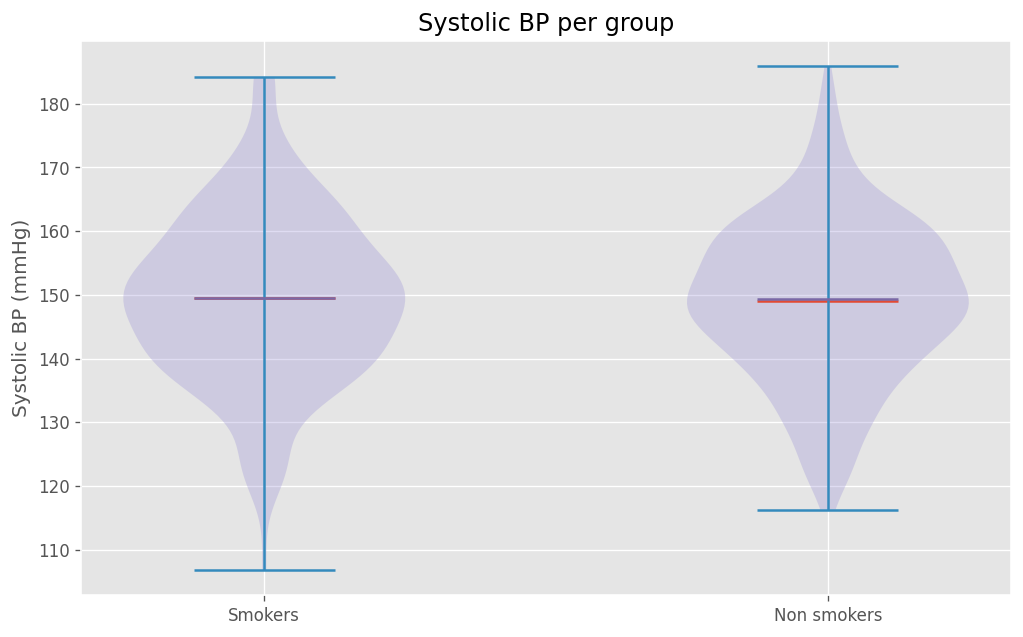

In [8]:
# Violin plot: systoliskt blodtryck efter grupp rökare/icke rökare
data = [smokers, non_smokers]

fig5, ax = plt.subplots()
vp = ax.violinplot(data, showmeans=True, showmedians=True)
for body in vp["bodies"]:
    body.set_facecolor("#988ED5")
vp["cmedians"].set_color("#7A68A6")
vp["cbars"].set_color("#348ABD")
vp["cmaxes"].set_color("#348ABD")
vp["cmins"].set_color("#348ABD")
ax.set_title("Systolic BP per group")
ax.set_ylabel("Systolic BP (mmHg)")
ax.set_xticks([1, 2])
ax.set_xticklabels(["Smokers", "Non smokers"])
fig5.savefig("img/fig5")
plt.show()

## Undersökning av hypotes­test säkerhet

I detta steg undersöker vi hur känsligt vårt t-test är för att upptäcka en verklig skillnad i blodtryck mellan rökare och icke-rökare.  
Poweranalysen kompletterar hypotesprövningen genom att svara på frågan:
**”Skulle vi rimligen ha kunnat upptäcka en effekt om den fanns?”**

Vi beräknar power med tre metoder:  
1. **Effektstorlek (Cohen’s d)**  
2. **Teoretisk power** baserat på statistiska antaganden  
3. **Simulerad power** via Monte Carlo-simulering  
4. **Nödvändig effektstorlek** för att uppnå 80% power  

**Resultat**:  
Både teoretisk och simulerad styrka beräknades för att jämföra resultaten och kontrollera att simuleringen stämmer med de teoretiska förväntningarna.

Resultaten visar att den statistiska styrkan (power) är mycket låg, cirka **0,11**.  
Detta beror på att den observerade skillnaden i medelvärde (≈ **0,47 mmHg**) är mycket liten jämfört med variationen inom grupperna (SD ≈ **13 mmHg**).  

Låg power innebär inte bara att testet misslyckas med att hitta en signifikant skillnad — det innebär också att **testet inte hade rimliga förutsättningar att lyckas**.  

En vidare poweranalys visar att det skulle krävas en medelvärdesskillnad på ungefär **2,55 mmHg** för att uppnå **80% power**, vilket är flera gånger större än den observerade skillnaden.  

Detta bekräftar att resultatet från hypotesprövningen (icke-signifikant skillnad) är helt i linje med de mycket små effekter som observerats.  

**Tolkning**:  
I praktiken tyder detta på att rökstatus **inte är förknippad med någon kliniskt eller statistiskt meningsfull förändring av systoliskt blodtryck** i detta urval.

In [9]:
# Power calculations
mathematical_power = theoretical_power(effect["effect size"], n_smokers, n_non_smokers, alpha=0.05)
simulated_power = simulate_ttest_power(smokers_mean, non_smokers_mean, sd_smokers, sd_non_smokers, n_smokers, n_non_smokers, alpha=0.05, n_sim=5000, seed=42)
required_power = power_analysis(n_smokers, n_non_smokers, sd_smokers, sd_non_smokers, diff_means, alpha=0.05, power_target=0.8)

summary2 = pd.DataFrame({
    "Metric": [
        "Cohen's d", "Pooled SD",
        "Theoretical power", "Simulated power",
        "Required mean diff", "Required d"
    ],
    "Value": [
        f"{effect["effect size"]:.3f}", f"{effect["pooled sd"]:.3f}",
        f"{mathematical_power:.3f}", f"{simulated_power["hits"]:.3f}",
        f"{required_power["required mean difference"]:.2f}",
        f"{required_power["required d"]:.3f}"
    ]
})

summary2


    För att uppnå 80.0% power skulle testet kräva en medelvärdesskillnad på cirka 2.55 mmHg (Cohen's d ≈ 0.20). 
    Den observerade skillnaden (≈ 0.47 mmHg) är mycket mindre, vilket förklarar den låga styrkan.
    


,Metric,Value
0,Cohen's d,0.037
1,Pooled SD,12.800
2,Theoretical power,0.118
3,Simulated power,0.106
4,Required mean diff,2.55
5,Required d,0.199


## Linjär regression - Prediktion av systoliskt blodtryck

I detta steg använder jag linjär algebra i praktiken för att modellera sambandet mellan systoliskt blodtryck och ålder. 
Jag använder en enkel linjär regression. 

**Resultat**:  
- Skärning (intercept): 122.685 mmHg  
- Koefficient för ålder: 0.536 mmHg/år   
- Förklarad varians (R²): 0.369  

**Tolkning**:  
- En ökning med 10 år i ålder förväntas ge en ökning av blodtrycket med cirka 5.36 mmHg, i genomsnitt.
- R²-värdet 0.37 indikerar att modellen förklarar ungefär 37% av variationen i systoliskt blodtryck med hjälp av ålder.  

**Visualisering**:  
- **Ålder vs Systoliskt blodtryck**: punkter visar individer, linjen visar modellens prediktion; visar sambandet mellan ålder och blodtryck.    
- **Residualplot**: visar skillnaden mellan observerat och predikterat blodtryck; slumpmässig spridning runt noll indikerar att modellen passar data väl.


Skärning (intercept)                 :  122.685
Koefficient för ålder (mmHg/år)      :  0.536
R^2                                  :  0.369

Tolkning av koefficienter:
- +10 år => 5.36 mmHg högre systoliskt blodtryck (i snitt)



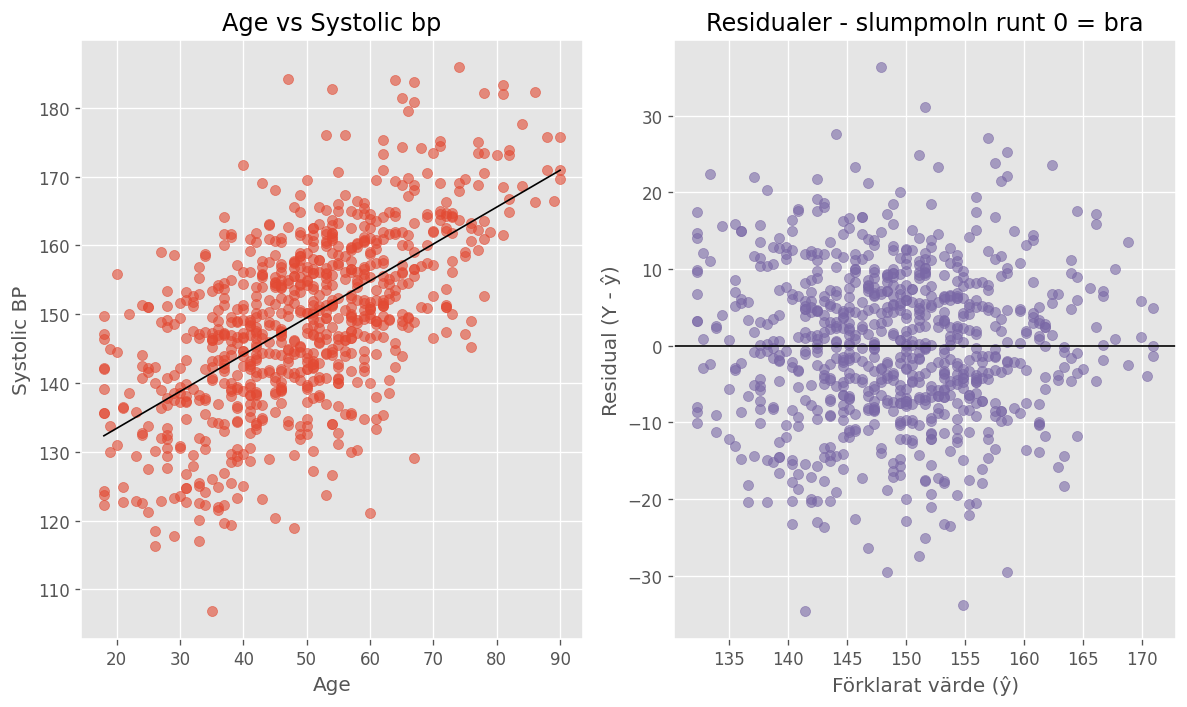

In [10]:
# Predict systolic blood pressure (SBP) from age and weight
X = df[["age"]].to_numpy() 
y = df["systolic_bp"].to_numpy() 

# Fit model
model = LinearRegression()
model.fit(X, y)

intercept_hat = float(model.intercept_)
coef_age = float(model.coef_[0])

# Predictions and residuals
y_hat = model.predict(X)
residuals = y - y_hat

# Manual R^2
ss_tot = np.sum((y - y.mean())**2)
ss_res = np.sum(residuals**2)
r2 = 1 - ss_res / ss_tot

print(f"""
Skärning (intercept)                 : {intercept_hat: .3f}
Koefficient för ålder (mmHg/år)      : {coef_age: .3f}
R^2                                  : {r2: .3f}

Tolkning av koefficienter:
- +10 år => {10 * coef_age:.2f} mmHg högre systoliskt blodtryck (i snitt)
""")

fig6, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(X[:,0], y, alpha=0.6)
x_line = np.linspace(X.min(), X.max(), 100)
y_line = intercept_hat + coef_age * x_line
ax1.plot(x_line, y_line, color="black", linewidth=1)
ax1.set_xlabel("Age")
ax1.set_ylabel("Systolic BP")
ax1.set_title("Age vs Systolic bp")

ax2.scatter(y_hat, residuals, color="#7A68A6", alpha=0.6)
ax2.axhline(0, color="black", linewidth=1)
ax2.set_xlabel("Förklarat värde (ŷ)")
ax2.set_ylabel("Residual (Y - ŷ)")
ax2.set_title("Residualer - slumpmoln runt 0 = bra")
plt.tight_layout()
fig6.savefig("img/fig6")
plt.show()

## PCA – Identifiering av mönster i data

I detta steg har jag använt Principal Component Analysis (PCA) för att reducera datans komplexitet och visualisera de huvudsakliga variationerna. 

**Resultat och tolkning**:  
- **PC1 (x-axeln, varians: 0.406)** verkar representera faktorer relaterade till ålder och kardiovaskulär hälsa, eftersom den fångar den största variationen i data. Den påverkas mest av ålder(0.573), systoliskt blodtryck(0.569) och kolesterol(0.526). Punkter längre åt vänster eller höger avviker mer från genomsnittet i dessa variabler.
  
- **PC2 (y-axeln, varians: 0.260)** captures body size characteristics (height and weight). fångar näst största variationen, här relaterad till skillnader i längd (0.694) och vikt (0.657).  
  
**Tolkning av plott**:  
Data bildar en tät ellipsliknande klunga med spridning längs PC1 och PC2. Detta indikerar att det inte finns tydliga separata grupper, utan snarare en kontinuerlig variation mellan individer i datasetet. Punkter som ligger längre från centrum representerar individer som avviker mer från genomsnittet i kombinationen av variabler som påverkar respektive principal component.  
  
PCA hjälper oss alltså att förstå vilka variabler som driver de största skillnaderna och att identifiera eventuella mönster i data på ett visuellt sätt.

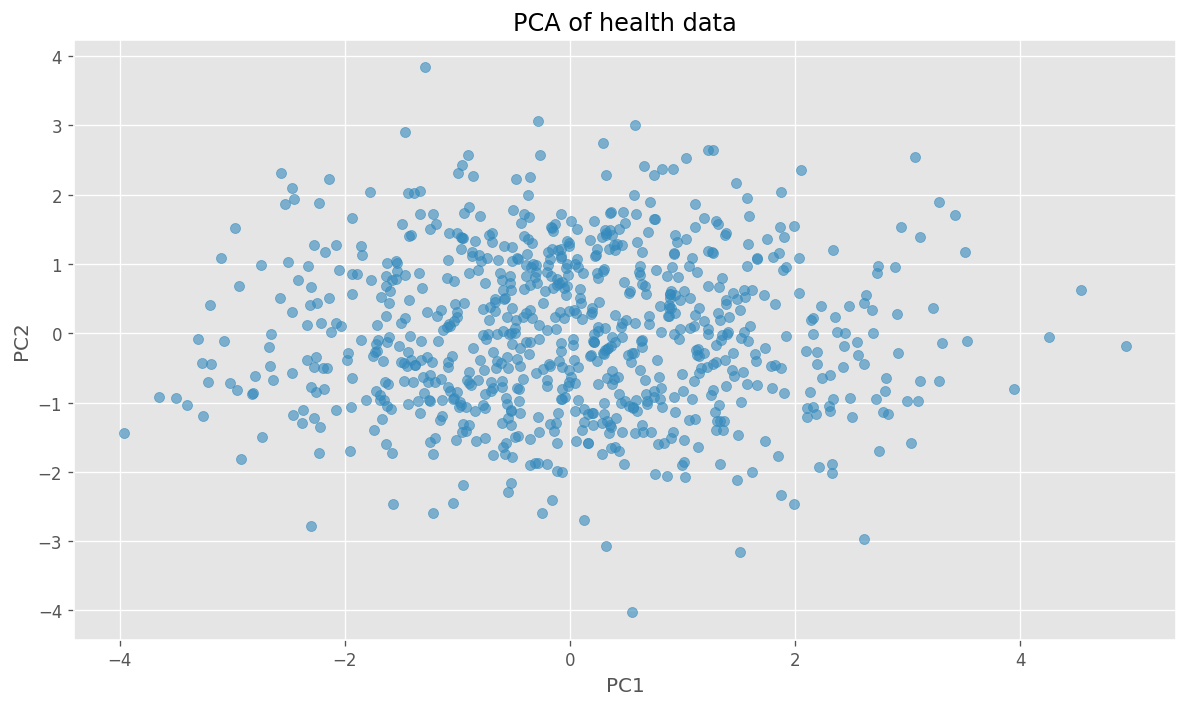

Selected numeric variables: age, height, weight, systolic_bp, cholesterol
PC1 (variance: 0.409): [0.573 0.098 0.247 0.569 0.526]
PC2 (variance: 0.260): [-0.28   0.694  0.657 -0.059 -0.069]


In [11]:
# Selecting numeric variables
X = df[["age", "height", "weight", "systolic_bp", "cholesterol"]]

# scale features
X_scaled = StandardScaler().fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Explained variance
explained_variance = pca.explained_variance_ratio_

fig7, ax = plt.subplots()
ax.scatter(principal_components[:,0], principal_components[:,1],
            color="#348ABD", alpha=0.6)
ax.set_title("PCA of health data")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
plt.tight_layout()
fig7.savefig("img/fig7")
plt.show()

print("Selected numeric variables: age, height, weight, systolic_bp, cholesterol")
for i, (component, var_ratio) in enumerate(zip(pca.components_, explained_variance), 1):
    print(f"PC{i} (variance: {var_ratio:.3f}): {component}")

## Multipel linjär regression

Syftet med denna analys var att undersöka vilka faktorer som mest påverkar systoliskt blodtryck i vår dataset. Vi har flera möjliga prediktorer (ålder, vikt, längd, kolesterol) och vill förstå deras relativa bidrag, samt jämföra effektstorlekar på ett standardiserat sätt.  

Därför valdes **multipel linjär regression** som metod. Multipel regression är lämplig när vi vill modellera sambandet mellan en kontinuerlig beroende variabel (här: systoliskt blodtryck) och flera oberoende variabler, samt kontrollera för deras ömsesidiga påverkan.

**Datapreparation:**  
Prediktorerna (ålder, vikt, längd, kolesterol) standardiserades med `StandardScaler`. Genom standardisering av prediktorer kan vi jämföra relativa effekter för att förstå vilka variabler som är mest relevanta och hur mycket de bidrar till variationen i blodtrycket.

**Resultat**
Standardiserade koefficienter:

| Variabel    | Standardiserad koefficient (mmHg per SD) |
|------------|------------------------------------------|
| Ålder      | 7.59                                     |
| Vikt       | 2.16                                     |
| Längd      | 0.47                                     |
| Kolesterol | 0.45                                     |

- **Ålder** är den starkast påverkande faktorn: en ökning med en standardavvikelse förväntas öka systoliskt blodtryck med ~7.6 mmHg.  
- **Vikt** har en måttlig effekt (~2.2 mmHg per SD).  
- **Längd och kolesterol** har mycket små effekter.  
- Modellen förklarar cirka **41% av variationen** i systoliskt blodtryck (R² ≈ 0.41).

**Slutsats**
Analysen visar att **ålder och vikt är de mest betydelsefulla faktorerna** för systoliskt blodtryck i denna dataset. Modellen förklarar cirka 41% av variationen i blodtrycket, vilket innebär att en stor del av variationen fortfarande inte förklaras av de inkluderade variablerna. Detta tyder på att ytterligare faktorer kan behöva undersökas för att bättre förstå variationen i systoliskt blodtryck.

In [12]:
# Target
y_multiple = df["systolic_bp"]

# Standardize predictors
scaler = StandardScaler()
X_multiple = scaler.fit_transform(df[["age", "weight", "height", "cholesterol"]])

# Fit model
regr = LinearRegression()
regr.fit(X_multiple, y_multiple)

# Coefficients
intercept_hat_multiple = float(regr.intercept_)
coef_names = ["age", "weight", "height", "cholesterol"]
coefficients = regr.coef_

# Predictions and residuals
y_hat_multiple = regr.predict(X_multiple)
residuals_multiple = y_multiple - y_hat_multiple

# R²
from sklearn.metrics import r2_score
r2_multiple = r2_score(y_multiple, y_hat_multiple)

print("Standardized coefficients (effect per 1 SD increase):")
for name, coef in zip(coef_names, coefficients):
    print(f"{name:12}: {coef:.3f} mmHg per SD")
print(f"""
R²          : {r2_multiple:.3f}
      
Tolkning:
- Ålder har störst påverkan på systoliskt blodtryck, följt av vikt.
- Längd och kolesterol har relativt små effekter.
- Modellen förklarar cirka {r2_multiple*100:.2f}% av variationen i blodtrycket.""")

Standardized coefficients (effect per 1 SD increase):
age         : 7.586 mmHg per SD
weight      : 2.161 mmHg per SD
height      : 0.466 mmHg per SD
cholesterol : 0.451 mmHg per SD

R²          : 0.407

Tolkning:
- Ålder har störst påverkan på systoliskt blodtryck, följt av vikt.
- Längd och kolesterol har relativt små effekter.
- Modellen förklarar cirka 40.70% av variationen i blodtrycket.


In [13]:
# Prediction
def predict_bp(age, weight, height, cholesterol):
    """
    Predict systoliskt blodtryck baserat på multipel linjär regression.
    Använder samma scaler och modell som tränades tidigare.
    """
    # Prepare input
    person_df = pd.DataFrame([[age, weight, height, cholesterol]], columns=["age", "weight", "height", "cholesterol"]
    ) 
    
    # Scale using the trained scaler
    person_scaled = scaler.transform(person_df)
    
    # Predict
    prediction = regr.predict(person_scaled)[0]
    
    return prediction

person1 = predict_bp(20, 55, 163, 4.71)
person2 = predict_bp(80, 80, 170, 6)
person1, person2

(np.float64(130.32794316059972), np.float64(166.7055419675834))

## Multipel linjär regression - Visualiseringar

- **Standardiserade koefficienter**: 
   - Stapeldiagrammet visar effekten av varje prediktor på blodtrycket per en standardavvikelse.  
   - Ålder och vikt har störst påverkan, medan längd och kolesterol påverkar mindre.

- **Predikterat vs observerat blodtryck**: 
   - Scatterplotten visar hur väl modellen predicerar blodtrycket.  
   - Punkter nära den svarta streckad linjen indikerar bra passform, medan avvikelser visar där modellen inte träffar exakt.

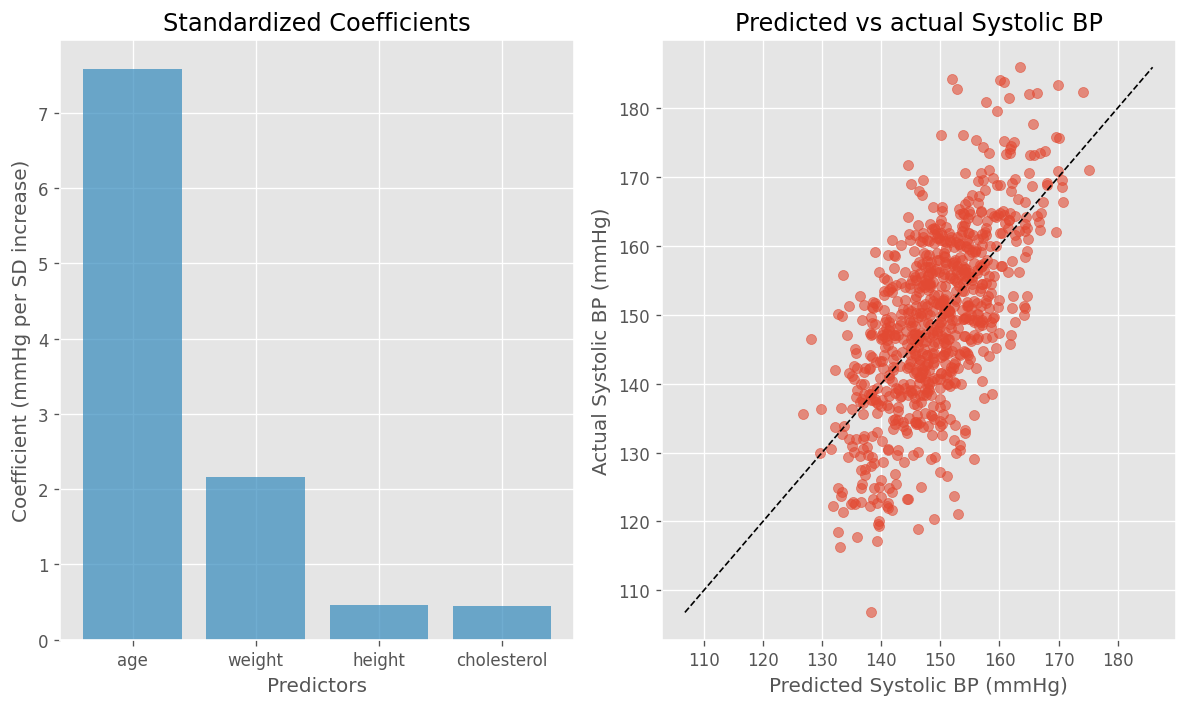

In [14]:
fig8, (ax1, ax2) = plt.subplots(1, 2)

# Bar chart of coefficients
ax1.bar(coef_names, coefficients, color="#348ABD", alpha=0.7)
ax1.set_title("Standardized Coefficients")
ax1.set_xlabel("Predictors")
ax1.set_ylabel("Coefficient (mmHg per SD increase)")

# Scatter of predicted vs actual
ax2.scatter(y_hat_multiple, y_multiple, alpha=0.6)
ax2.plot([min(y_multiple), max(y_multiple)], [min(y_multiple), max(y_multiple)], "k--", lw=1)
ax2.set_title("Predicted vs actual Systolic BP")
ax2.set_xlabel("Predicted Systolic BP (mmHg)")
ax2.set_ylabel("Actual Systolic BP (mmHg)")

fig8.savefig("img/fig8")
plt.tight_layout()
plt.show()

## Källor  

**Konfidensintervall**:  
- https://www.youtube.com/watch?v=xjYEYBvPaSc [13/11/2025]  

**ttest_ind**:  
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html [12/11/2025]

**solve_power**:  
- https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.power.ttestindpower.solve_power [12/11/2025]  
- https://www.statsmodels.org/stable/generated/statsmodels.stats.power.TTestPower.solve_power.html#statsmodels.stats.power.TTestPower.solve_power [12/11/2025]

**Docstrings**:  
- https://numpydoc.readthedocs.io/en/latest/format.html

**Linjär Regression**:  
- https://www.youtube.com/watch?v=ZsJ-DbKpD3s&t=4036s

**PCA**:  
- https://www.geeksforgeeks.org/data-analysis/principal-component-analysis-pca/
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

**Multipel Regression**:
- https://www.w3schools.com/python/python_ml_multiple_regression.asp
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
- *Scaling*: 
    - https://www.w3schools.com/python/python_ml_scale.asp
    - https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html